# Partícula Libre

In [ ]:
# Simulación de una partícula libre con dinámica de Langevin

import numpy as np
import pickle
from tqdm import tqdm
import simtk.openmm as mm
import simtk.openmm.app as app
import simtk.unit as unit


num_particles = 1
mass = 180.15 * unit.amu # masa de la glucosa

temperature = 300*unit.kelvin
friction = 5.0/unit.picosecond

step_size = 0.1*unit.picoseconds
steps_per_period = 100
num_periods = 500000
trajectory_file = '1_free_particle.pkl'


system = mm.System()

for ii in range(num_particles):
    system.addParticle(mass)

integrator = mm.LangevinIntegrator(temperature, friction, step_size)

platform_name = 'CUDA'
platform = mm.Platform.getPlatformByName(platform_name)

context = mm.Context(system, integrator, platform)

initial_positions  = np.zeros([num_particles, 3], np.float32) * unit.angstroms
initial_velocities = np.zeros([num_particles, 3], np.float32) * unit.angstroms/unit.picoseconds

context.setPositions(initial_positions)
context.setVelocities(initial_velocities)

times = np.zeros([num_periods], np.float32) * unit.picoseconds
positions = np.zeros([num_periods, num_particles, 3], np.float32) * unit.angstroms
velocities = np.zeros([num_periods, num_particles, 3], np.float32) * unit.angstroms/unit.picosecond

state = context.getState(getPositions=True, getVelocities=True)
times[0] = state.getTime()
positions[0] = state.getPositions()
velocities[0] = state.getVelocities()

for ii in tqdm(range(1,num_periods)):
    context.getIntegrator().step(steps_per_period)
    state = context.getState(getPositions=True, getVelocities=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()
    velocities[ii] = state.getVelocities()

file = open(trajectory_file,'wb')
pickle.dump( times, file )
pickle.dump( positions, file )
pickle.dump( velocities, file )
file.close()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import simtk.openmm as mm
import simtk.unit as unit
import simtk.openmm.app as app
from tqdm import tqdm

# Definición del sistema

Un partícula libre de masa unidad

In [2]:
# One particle in 3D
system = mm.System()
mass = 39.948 * unit.amu # masa del átomo de argón
system.addParticle(mass)

0

# Estado termodinámico

In [3]:
# Formalismo NVT
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
temperature = 300*unit.kelvin
pressure    = None

# Parametros de la simulación

In [4]:
step_size       = 0.001*unit.picoseconds
num_steps       = 1000000
saving_period   = 100
num_steps_saved = int(num_steps/saving_period)

# Integrador

#### Langevin

In [5]:
friction    = 5.0/unit.picosecond
integrator = mm.LangevinIntegrator(temperature, friction, step_size)

# Plataforma

In [6]:
platform_name='CPU'  #platform:     A platform (CPU, OpenCL, CUDA, or reference); default is platform=OpenCL"
# for ii in range(mm.Platform.getNumPlatforms()):
#     print(mm.Platform.getPlatform(ii).getName())
platform = mm.Platform.getPlatformByName(platform_name)

# Reporteros y arrays de salida

In [7]:
times      = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.picoseconds)
positions  = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.angstroms)
velocities = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.angstroms/unit.picosecond)
potential_energies   = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)
kinetic_energies     = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)

# Condiciones iniciales

In [8]:
initial_positions  = [[0.0, 0.0, 0.0]] * unit.angstroms
#initial_velocities = None # Las velocidades serán adjudicadas aleatoriamente según la distribución Maxwell-Boltzmann del estado termodinámico

context = mm.Context(system, integrator, platform)
context.setPositions(initial_positions)
context.setVelocitiesToTemperature(temperature)

In [9]:
state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
times[0] = state.getTime()
positions[0] = state.getPositions()[0]
velocities[0] = state.getVelocities()[0]
kinetic_energies[0]=state.getKineticEnergy()
potential_energies[0]=state.getPotentialEnergy()

# Corriendo la simulación

In [10]:
for ii in tqdm(range(num_steps_saved)):
    context.getIntegrator().step(saving_period)
    state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()[0]
    velocities[ii] = state.getVelocities()[0]
    kinetic_energies[ii]=state.getKineticEnergy()
    potential_energies[ii]=state.getPotentialEnergy()

100%|██████████| 10000/10000 [01:36<00:00, 103.12it/s]


# Análisis de resultados

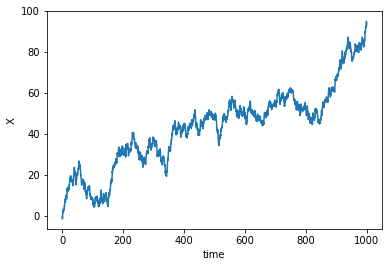

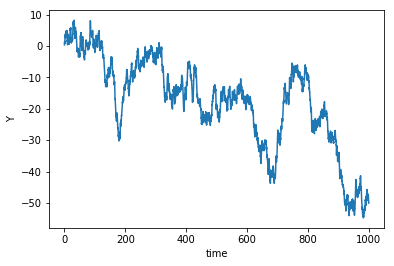

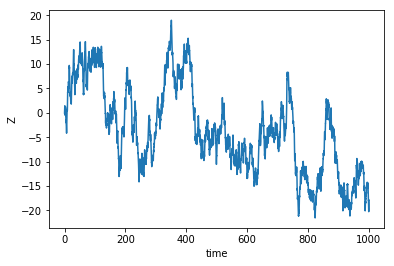

In [11]:
for ii, ylabel in zip(range(3),['X','Y','Z']):
    plt.plot(times,positions[:,ii])
    plt.ylabel(ylabel)
    plt.xlabel('time')
    plt.show()

*Puedo calcular el tiempo de decorrelación?, el tiempo de memoria...*

In [12]:
## Energía libre en función de la temperatura